Reading 0 ... 18874  =      0.000 ...  2415.872 secs...
Tapping left: 5.411856322366285e-09
Control: 2.42198421884521e-09
Tapping Left vs. Control (HbO): t = 3.706, p = 0.001
Tapping Left vs. Control (HbR): t = 4.376, p = 0.000
Tapping right: 5.1893026984690995e-09
Tapping Right vs. Control (HbO): t = 3.372, p = 0.003
Tapping Right vs. Control (HbR): t = 3.551, p = 0.002
Reading 0 ... 18874  =      0.000 ...  2415.872 secs...
Control Split (HbO): t = 0.177, p = 0.863
Control Split (HbR): t = 1.334, p = 0.209
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


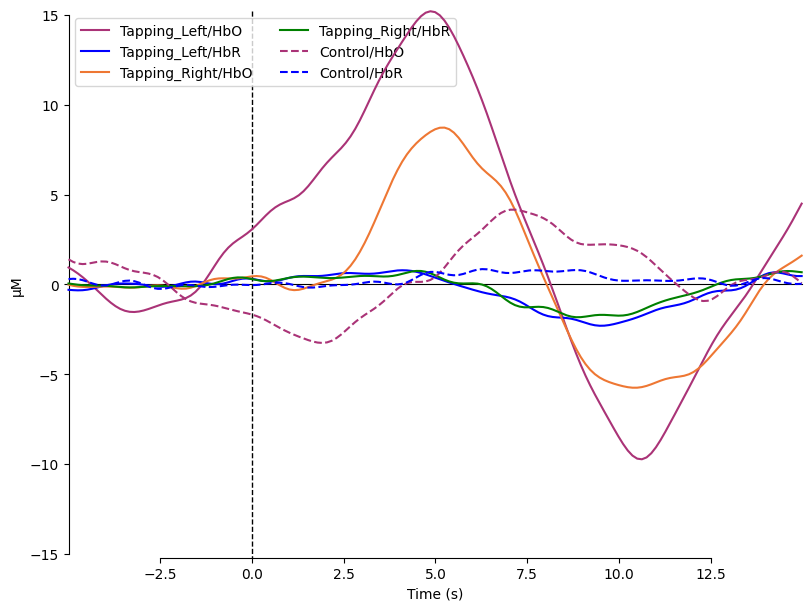

[<Figure size 800x600 with 1 Axes>]

In [16]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import mne
from scipy.stats import ttest_rel

# Insert the parent folder for custom modules
sys.path.insert(0, os.path.abspath('..'))
from Preprocessing.preprocessing_mne import get_raw_subject_data, get_raw_control_subject_data

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

def load_data(subject=3, time_window=(-5, 15)):
    """
    Load data, perform averaging tests and plots for evoked responses,
    and return concatenated data along with original epoch information.
    
    This function retains all mean tests and plots of averaged epochs.
    ICA-related functionality has been removed.
    
    Returns:
        tuple: (X, orig_indices, y, control_data, left_data, right_data, numb_samples)
    """

    # tmin = time_window[0]
    # tmax = time_window[1]
    tmin = -5.0
    tmax = 15.0

    # Load subject epochs
    epochs = get_raw_subject_data(subject=subject, tmin=tmin, tmax=tmax)

    # Compute evoked responses for each condition and rename channels
    evoked_dict = {
        "Tapping_Left/HbO": epochs["Tapping_Left"].average(picks="hbo"),
        "Tapping_Left/HbR": epochs["Tapping_Left"].average(picks="hbr"),
        "Tapping_Right/HbO": epochs["Tapping_Right"].average(picks="hbo"),
        "Tapping_Right/HbR": epochs["Tapping_Right"].average(picks="hbr"),
        "Control/HbO": epochs["Control"].average(picks="hbo"),
        "Control/HbR": epochs["Control"].average(picks="hbr"),
    }
    for condition in evoked_dict:
        evoked_dict[condition].rename_channels(lambda x: x[:-4])

    return epochs, evoked_dict


def extract_epoch_means(epochs_obj, time_window, pick_type):
    """
    Compute the mean power for each epoch over channels and a time window.
    
    Parameters:
        epochs_obj: MNE Epochs object.
        time_window: tuple (t_min, t_max) in seconds.
        pick_type: string (e.g., 'hbo' or 'hbr').
    
    Returns:
        1D array with mean power (i.e., average of the squared signal) for each epoch.
    """
    data = epochs_obj.get_data(picks=pick_type)
    idx = np.where((epochs_obj.times >= time_window[0]) & (epochs_obj.times <= time_window[1]))[0]
    return np.mean(np.square(data[:, :, idx]), axis=(1, 2))


def plot_mean_evoked_responses(evoked_dict, color_dict, styles_dict):
    """
    Plot the mean evoked responses (averaging over channels) for each condition.
    """
    plt.figure(figsize=(10, 6))
    for condition, ev in evoked_dict.items():
        mean_signal = np.mean(ev.data, axis=0)
        cond_key = condition.split('/')[0]
        linestyle = styles_dict.get(cond_key, {}).get("linestyle", "-")
        color = color_dict.get(condition)
        plt.plot(ev.times, mean_signal, label=condition, color=color, linestyle=linestyle)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Mean Evoked Response (Channels Averaged)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


# def perform_t_tests(epochs, time_window):
#     """
#     Compute paired t-tests for tapping versus control epochs.
#     """
#     tapping_hbo = extract_epoch_means(epochs["Tapping_Left"], time_window, "hbo")
#     control_hbo = extract_epoch_means(epochs["Control"], time_window, "hbo")
#     tapping_hbr = extract_epoch_means(epochs["Tapping_Left"], time_window, "hbr")
#     control_hbr = extract_epoch_means(epochs["Control"], time_window, "hbr")

#     n_epochs = min(tapping_hbo.shape[0], control_hbo.shape[0])
#     tapping_hbo, control_hbo = tapping_hbo[:n_epochs], control_hbo[:n_epochs]
#     tapping_hbr, control_hbr = tapping_hbr[:n_epochs], control_hbr[:n_epochs]

#     t_stat_hbo, p_val_hbo = ttest_rel(tapping_hbo, control_hbo)
#     t_stat_hbr, p_val_hbr = ttest_rel(tapping_hbr, control_hbr)

#     print("Tapping vs. Control (HbO): t = {:.3f}, p = {:.3f}".format(t_stat_hbo, p_val_hbo))
#     print("Tapping vs. Control (HbR): t = {:.3f}, p = {:.3f}".format(t_stat_hbr, p_val_hbr))

def perform_t_tests(epochs, time_window):
    """
    Compute paired t-tests for tapping (left and right) versus control epochs.
    """
    # Tapping Left vs. Control
    tapping_left_hbo = extract_epoch_means(epochs["Tapping_Left"], time_window, "hbo")
    print(f"Tapping left: {sum(tapping_left_hbo)}")
    control_hbo = extract_epoch_means(epochs["Control"], time_window, "hbo")
    print(f"Control: {sum(control_hbo)}")
    tapping_left_hbr = extract_epoch_means(epochs["Tapping_Left"], time_window, "hbr")
    control_hbr = extract_epoch_means(epochs["Control"], time_window, "hbr")
    
    n_epochs_left = min(tapping_left_hbo.shape[0], control_hbo.shape[0])
    tapping_left_hbo, control_hbo_left = tapping_left_hbo[:n_epochs_left], control_hbo[:n_epochs_left]
    tapping_left_hbr, control_hbr_left = tapping_left_hbr[:n_epochs_left], control_hbr[:n_epochs_left]
    
    t_stat_left_hbo, p_val_left_hbo = ttest_rel(tapping_left_hbo, control_hbo_left)
    t_stat_left_hbr, p_val_left_hbr = ttest_rel(tapping_left_hbr, control_hbr_left)
    
    print("Tapping Left vs. Control (HbO): t = {:.3f}, p = {:.3f}".format(t_stat_left_hbo, p_val_left_hbo))
    print("Tapping Left vs. Control (HbR): t = {:.3f}, p = {:.3f}".format(t_stat_left_hbr, p_val_left_hbr))
    
    # Tapping Right vs. Control
    tapping_right_hbo = extract_epoch_means(epochs["Tapping_Right"], time_window, "hbo")
    print(f"Tapping right: {sum(tapping_right_hbo)}")
    tapping_right_hbr = extract_epoch_means(epochs["Tapping_Right"], time_window, "hbr")
    
    n_epochs_right = min(tapping_right_hbo.shape[0], control_hbo.shape[0])
    tapping_right_hbo, control_hbo_right = tapping_right_hbo[:n_epochs_right], control_hbo[:n_epochs_right]
    tapping_right_hbr, control_hbr_right = tapping_right_hbr[:n_epochs_right], control_hbr[:n_epochs_right]
    
    t_stat_right_hbo, p_val_right_hbo = ttest_rel(tapping_right_hbo, control_hbo_right)
    t_stat_right_hbr, p_val_right_hbr = ttest_rel(tapping_right_hbr, control_hbr_right)
    
    print("Tapping Right vs. Control (HbO): t = {:.3f}, p = {:.3f}".format(t_stat_right_hbo, p_val_right_hbo))
    print("Tapping Right vs. Control (HbR): t = {:.3f}, p = {:.3f}".format(t_stat_right_hbr, p_val_right_hbr))


def perform_control_split_t_tests(subject, time_window):
    """
    Split control epochs randomly into two sets and compute
    paired t-tests for the activation over the given time window.
    """
    control_epochs = get_raw_control_subject_data(subject=subject)
    data = control_epochs.get_data()
    n_epochs = data.shape[0]
    perm = np.random.permutation(n_epochs)
    half = n_epochs // 2
    set1_indices = perm[:half]
    set2_indices = perm[half:half*2]

    control_set1 = control_epochs[set1_indices]
    control_set2 = control_epochs[set2_indices]

    mean_set1_hbo = extract_epoch_means(control_set1, time_window, "hbo")
    mean_set2_hbo = extract_epoch_means(control_set2, time_window, "hbo")
    mean_set1_hbr = extract_epoch_means(control_set1, time_window, "hbr")
    mean_set2_hbr = extract_epoch_means(control_set2, time_window, "hbr")

    t_stat_hbo, p_val_hbo = ttest_rel(mean_set1_hbo, mean_set2_hbo)
    t_stat_hbr, p_val_hbr = ttest_rel(mean_set1_hbr, mean_set2_hbr)

    print("Control Split (HbO): t = {:.3f}, p = {:.3f}".format(t_stat_hbo, p_val_hbo))
    print("Control Split (HbR): t = {:.3f}, p = {:.3f}".format(t_stat_hbr, p_val_hbr))


subject = 2
time_window = (0, 11)

epochs, evoked_dict = load_data(subject=subject, time_window=time_window)

color_dict = {
"Tapping_Left/HbO": "#AA3377",
"Tapping_Left/HbR": "b",
"Tapping_Right/HbO": "#EE7733",
"Tapping_Right/HbR": "g",
"Control/HbO": "#AA3377",
"Control/HbR": "b",
}
styles_dict = dict(Control=dict(linestyle="dashed"))

# Perform paired t-tests for tapping vs. control
perform_t_tests(epochs, time_window)
# Perform control split t-tests
perform_control_split_t_tests(subject, time_window)

# Plot evoked comparisons using MNE's viz
mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)

In [ ]:
# =========================  APPEND FROM HERE  =========================
import mne
from numpy.random import default_rng
import numpy as np
from tqdm import tqdm  # added progress bar support

# ----------  helpers  ----------
def _rms(x):
    """Root-mean-square of an array."""
    return np.sqrt(np.mean(np.square(x)))


def _grand_avg_rms(epochs):
    """
    RMS of the grand-average signal, averaged over both HbO & HbR channels.
    This is sensitive to inter-trial phase alignment: random-phase control
    averages toward 0, whereas phase-locked tapping retains amplitude.
    """
    hbo_rms = _rms(epochs.average(picks="hbo").data)
    hbr_rms = _rms(epochs.average(picks="hbr").data)
    return (hbo_rms + hbr_rms) / 2


def permutation_rms_test(epochs_a, epochs_b, *, n_perm=5000, seed=42):
    """
    Non-parametric permutation test on the RMS of the grand-average signal.
    Returns the observed RMS difference (A − B) and a two-sided p-value.
    """
    rng = default_rng(seed)
    all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
    n_a = len(epochs_a)

    observed = _grand_avg_rms(epochs_a) - _grand_avg_rms(epochs_b)
    null_dist = np.empty(n_perm)

    # Added progress bar for the permutation loop
    for i in tqdm(range(n_perm), desc="Permutations"):
        idx = rng.permutation(len(all_ep))
        ep_a = all_ep[idx[:n_a]]
        ep_b = all_ep[idx[n_a:]]
        null_dist[i] = _grand_avg_rms(ep_a) - _grand_avg_rms(ep_b)

    p_val = (np.sum(np.abs(null_dist) >= abs(observed)) + 1) / (n_perm + 1)
    return observed, p_val


def _split_random_half(epochs, *, seed=99):
    """Randomly split an Epochs object into two equal halves (±1 epoch)."""
    rng = default_rng(seed)
    idx = rng.permutation(len(epochs))
    half = len(epochs) // 2
    return epochs[idx[:half]], epochs[idx[half:half * 2]]


# ----------  phase-alignment test: Tapping vs Control  ----------
# (combine left & right tapping for maximum power)
tapping_epochs = mne.concatenate_epochs(
    [epochs["Tapping_Left"], epochs["Tapping_Right"]]
)
control_epochs = epochs["Control"]

obs_diff, p_val = permutation_rms_test(tapping_epochs, control_epochs, n_perm=5000)
print(
    f"Phase-alignment test (Tapping − Control): "
    f"ΔRMS = {obs_diff:.4f}, p = {p_val:.4g}"
)

# ----------  sanity-check: Control half vs half  ----------
c_half1, c_half2 = _split_random_half(control_epochs)
obs_ctrl, p_ctrl = permutation_rms_test(c_half1, c_half2, n_perm=5000)
print(
    f"Control split check (half 1 − half 2): "
    f"ΔRMS = {obs_ctrl:.4f}, p = {p_ctrl:.4g}"
)
# =========================  END APPEND  =========================


Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
43 matching events found
Applying baseline correction (mode: mean)


/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_76023/3544826193.py:57: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  tapping_epochs = mne.concatenate_epochs(
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_76023/3544826193.py:30: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations:  17%|█▋        | 834/5000 [00:04<00:20, 204.91it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x112018790>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Permutations:  63%|██████▎   | 3149/5000 [00:15<00:09, 204.52it/s]

In [17]:
# =========================  APPEND FROM HERE  =========================
import mne
from numpy.random import default_rng
import numpy as np
from tqdm import tqdm  # added progress bar support

# ----------  helpers  ----------
def _rms(x):
    """Root-mean-square of an array."""
    return np.sqrt(np.mean(np.square(x)))


def _grand_avg_rms(epochs):
    """
    RMS of the grand-average signal, averaged over both HbO & HbR channels.
    This is sensitive to inter-trial phase alignment: random-phase control
    averages toward 0, whereas phase-locked tapping retains amplitude.
    """
    hbo_rms = _rms(epochs.average(picks="hbo").data)
    hbr_rms = _rms(epochs.average(picks="hbr").data)
    return (hbo_rms + hbr_rms) / 2


def permutation_rms_test(epochs_a, epochs_b, *, n_perm=5000, seed=42):
    """
    Non-parametric permutation test on the RMS of the grand-average signal.
    Returns the observed RMS difference (A − B) and a two-sided p-value.
    """
    rng = default_rng(seed)
    all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
    n_a = len(epochs_a)

    observed = _grand_avg_rms(epochs_a) - _grand_avg_rms(epochs_b)
    null_dist = np.empty(n_perm)

    # Added progress bar for the permutation loop
    for i in tqdm(range(n_perm), desc="Permutations"):
        idx = rng.permutation(len(all_ep))
        ep_a = all_ep[idx[:n_a]]
        ep_b = all_ep[idx[n_a:]]
        null_dist[i] = _grand_avg_rms(ep_a) - _grand_avg_rms(ep_b)

    p_val = (np.sum(np.abs(null_dist) >= abs(observed)) + 1) / (n_perm + 1)
    return observed, p_val


def _split_random_half(epochs, *, seed=99):
    """Randomly split an Epochs object into two equal halves (±1 epoch)."""
    rng = default_rng(seed)
    idx = rng.permutation(len(epochs))
    half = len(epochs) // 2
    return epochs[idx[:half]], epochs[idx[half:half * 2]]


# ----------  mix control epochs into tapping epochs  ----------
# Adjust this float to change the fraction of tapping epochs to be replaced by control data.
control_mix_fraction = 0.0  # 0.50 means half of the tapping data will be replaced by control epochs.

# Combine tapping epochs from left and right
tapping_epochs_orig = mne.concatenate_epochs([epochs["Tapping_Left"], epochs["Tapping_Right"]])
n_tap_orig = len(tapping_epochs_orig)
n_replace = int(control_mix_fraction * n_tap_orig)

# Ensure there are enough control epochs available
available_ctrl = len(epochs["Control"])
n_replace = min(n_replace, available_ctrl)

rng_mix = default_rng(seed=42)
# Randomly choose indices from the original tapping epochs to replace
replace_idx = rng_mix.choice(np.arange(n_tap_orig), size=n_replace, replace=False)
remaining_idx = np.setdiff1d(np.arange(n_tap_orig), replace_idx)
# Randomly select corresponding control epochs to mix in
control_sample_indices = rng_mix.choice(np.arange(available_ctrl), size=n_replace, replace=False)

# Create the mixed tapping epochs: keep some tapping epochs and add in the sampled control epochs
mixed_tapping_epochs = mne.concatenate_epochs([tapping_epochs_orig[remaining_idx],
                                               epochs["Control"][control_sample_indices]])


# ----------  phase-alignment test: Mixed Tapping vs Control  ----------
# Now use the mixed tapping epochs instead of the pure tapping epochs.
control_epochs = epochs["Control"]

obs_diff, p_val = permutation_rms_test(mixed_tapping_epochs, control_epochs, n_perm=5000)
print(
    f"Phase-alignment test (Mixed Tapping − Control): "
    f"ΔRMS = {obs_diff:.4f}, p = {p_val:.4g}"
)

# ----------  sanity-check: Control half vs half  ----------
c_half1, c_half2 = _split_random_half(control_epochs)
obs_ctrl, p_ctrl = permutation_rms_test(c_half1, c_half2, n_perm=5000)
print(
    f"Control split check (half 1 − half 2): "
    f"ΔRMS = {obs_ctrl:.4f}, p = {p_ctrl:.4g}"
)
# =========================  END APPEND  =========================

Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)


/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/3652426237.py:60: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  tapping_epochs_orig = mne.concatenate_epochs([epochs["Tapping_Left"], epochs["Tapping_Right"]])
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/3652426237.py:76: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mixed_tapping_epochs = mne.concatenate_epochs([tapping_epochs_orig[remaining_idx],
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/3652426237.py:76: RuntimeWarning: One of the Epochs objects to concatenate was empty.
  mixed_tapping_epochs = mne.concatenate_epochs([tapping_epochs_orig[remaining_idx],
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/3652426237.py:76: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to chec

Phase-alignment test (Mixed Tapping − Control): ΔRMS = 0.0000, p = 0.08138
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/3652426237.py:30: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/3652426237.py:30: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations:  23%|██▎       | 1173/5000 [00:05<00:19, 201.30it/s]


KeyboardInterrupt: 

In [18]:
# =========================  APPEND FROM HERE  =========================
import mne
from numpy.random import default_rng
import numpy as np
from tqdm import tqdm  # added progress bar support

# ----------  helpers  ----------
def _rms(x):
    """Root-mean-square of an array."""
    return np.sqrt(np.mean(np.square(x)))


def avg_rms_pick(epochs, pick):
    """
    RMS of the channel-averaged signal using a specific pick.
    """
    evoked = epochs.average(picks=pick)
    return _rms(evoked.data)


def permutation_rms_test_pick(epochs_a, epochs_b, *, pick, n_perm=5000, seed=42):
    """
    Non-parametric permutation test on the RMS of the channel-averaged signal for a given pick.
    Returns the observed difference (A − B) and a two-sided p-value.
    """
    rng = default_rng(seed)
    all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
    n_a = len(epochs_a)

    observed = avg_rms_pick(epochs_a, pick) - avg_rms_pick(epochs_b, pick)
    null_dist = np.empty(n_perm)

    for i in tqdm(range(n_perm), desc=f"Permutations ({pick})"):
        idx = rng.permutation(len(all_ep))
        ep_a = all_ep[idx[:n_a]]
        ep_b = all_ep[idx[n_a:]]
        null_dist[i] = avg_rms_pick(ep_a, pick) - avg_rms_pick(ep_b, pick)

    p_val = (np.sum(np.abs(null_dist) >= abs(observed)) + 1) / (n_perm + 1)
    return observed, p_val


def _split_random_half(epochs, *, seed=99):
    """Randomly split an Epochs object into two equal halves (±1 epoch)."""
    rng = default_rng(seed)
    idx = rng.permutation(len(epochs))
    half = len(epochs) // 2
    return epochs[idx[:half]], epochs[idx[half:half * 2]]


# ----------  Phase-Alignment Tests  ----------
# Test 1: Tapping_Left vs. Control (HbO)
obs_diff_left_hbo, p_val_left_hbo = permutation_rms_test_pick(epochs["Tapping_Left"], epochs["Control"],
                                                              pick="hbo", n_perm=5000)
print(f"Phase-alignment test (Tapping_Left vs Control, HbO): ΔRMS = {obs_diff_left_hbo:.4f}, p = {p_val_left_hbo:.4g}")

# Test 2: Tapping_Left vs. Control (HbR)
obs_diff_left_hbr, p_val_left_hbr = permutation_rms_test_pick(epochs["Tapping_Left"], epochs["Control"],
                                                              pick="hbr", n_perm=5000)
print(f"Phase-alignment test (Tapping_Left vs Control, HbR): ΔRMS = {obs_diff_left_hbr:.4f}, p = {p_val_left_hbr:.4g}")

# Test 3: Tapping_Right vs. Control (HbO)
obs_diff_right_hbo, p_val_right_hbo = permutation_rms_test_pick(epochs["Tapping_Right"], epochs["Control"],
                                                                pick="hbo", n_perm=5000)
print(f"Phase-alignment test (Tapping_Right vs Control, HbO): ΔRMS = {obs_diff_right_hbo:.4f}, p = {p_val_right_hbo:.4g}")

# Test 4: Tapping_Right vs. Control (HbR)
obs_diff_right_hbr, p_val_right_hbr = permutation_rms_test_pick(epochs["Tapping_Right"], epochs["Control"],
                                                                pick="hbr", n_perm=5000)
print(f"Phase-alignment test (Tapping_Right vs Control, HbR): ΔRMS = {obs_diff_right_hbr:.4f}, p = {p_val_right_hbr:.4g}")


# ----------  Sanity-check: Control Half vs. Half  ----------
control_epochs = epochs["Control"]

# For HbO
c_half1, c_half2 = _split_random_half(control_epochs)
obs_ctrl_hbo, p_ctrl_hbo = permutation_rms_test_pick(c_half1, c_half2, pick="hbo", n_perm=5000)
print(f"Control split check (HbO): ΔRMS = {obs_ctrl_hbo:.4f}, p = {p_ctrl_hbo:.4g}")

# For HbR
c_half1, c_half2 = _split_random_half(control_epochs)
obs_ctrl_hbr, p_ctrl_hbr = permutation_rms_test_pick(c_half1, c_half2, pick="hbr", n_perm=5000)
print(f"Control split check (HbR): ΔRMS = {obs_ctrl_hbr:.4f}, p = {p_ctrl_hbr:.4g}")
# =========================  END APPEND  =========================

Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)


/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2562784608.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbo): 100%|██████████| 5000/5000 [00:15<00:00, 316.77it/s]

Phase-alignment test (Tapping_Left vs Control, HbO): ΔRMS = 0.0000, p = 0.0003999
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2562784608.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbr): 100%|██████████| 5000/5000 [00:15<00:00, 318.46it/s]

Phase-alignment test (Tapping_Left vs Control, HbR): ΔRMS = 0.0000, p = 0.008198
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2562784608.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbo): 100%|██████████| 5000/5000 [00:16<00:00, 306.19it/s]

Phase-alignment test (Tapping_Right vs Control, HbO): ΔRMS = 0.0000, p = 0.1116
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2562784608.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbr): 100%|██████████| 5000/5000 [00:16<00:00, 308.47it/s]

Phase-alignment test (Tapping_Right vs Control, HbR): ΔRMS = 0.0000, p = 0.3293
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2562784608.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2562784608.py:27: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbo): 100%|██████████| 5000/5000 [00:13<00:00, 358.60it/s]

Control split check (HbO): ΔRMS = -0.0000, p = 0.6763
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2562784608.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2562784608.py:27: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbr): 100%|██████████| 5000/5000 [00:14<00:00, 347.77it/s]

Control split check (HbR): ΔRMS = -0.0000, p = 0.3657


In [ ]:
# =========================  APPEND FROM HERE  =========================
import mne
from numpy.random import default_rng
import numpy as np
from scipy.stats import ttest_rel
from tqdm import tqdm  # added progress bar support

# --- Helper functions (existing) ---
def _rms(x):
    """Root-mean-square of an array."""
    return np.sqrt(np.mean(np.square(x)))

def avg_rms_pick(epochs, pick):
    """
    RMS of the channel-averaged signal using a specific pick.
    """
    evoked = epochs.average(picks=pick)
    return _rms(evoked.data)

def permutation_rms_test_pick(epochs_a, epochs_b, *, pick, n_perm=5000, seed=42):
    """
    Non-parametric permutation test on the RMS of the channel-averaged signal for a given pick.
    Returns the observed difference (A − B) and a two-sided p-value.
    """
    rng = default_rng(seed)
    all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
    n_a = len(epochs_a)
    observed = avg_rms_pick(epochs_a, pick) - avg_rms_pick(epochs_b, pick)
    null_dist = np.empty(n_perm)
    for i in tqdm(range(n_perm), desc=f"Permutations ({pick})"):
        idx = rng.permutation(len(all_ep))
        ep_a = all_ep[idx[:n_a]]
        ep_b = all_ep[idx[n_a:]]
        null_dist[i] = avg_rms_pick(ep_a, pick) - avg_rms_pick(ep_b, pick)
    p_val = (np.sum(np.abs(null_dist) >= abs(observed)) + 1) / (n_perm + 1)
    return observed, p_val

def _split_random_half(epochs, *, seed=99):
    """Randomly split an Epochs object into two equal halves (±1 epoch)."""
    rng = default_rng(seed)
    idx = rng.permutation(len(epochs))
    half = len(epochs) // 2
    return epochs[idx[:half]], epochs[idx[half:half*2]]

# --- New helper for average power test (modified) ---
def average_power_test(epochs_a, epochs_b, time_window, pick):
    """
    Compute a paired t-test for the average power from each epoch.
    The average power is computed over the specified time window using the
    existing extract_epoch_means function.
    If the groups have unequal number of epochs, truncate to the smallest sample.
    Returns the paired t-test p-value.
    """
    # Use the already-defined extract_epoch_means from the notebook
    data_a = extract_epoch_means(epochs_a, time_window, pick)
    data_b = extract_epoch_means(epochs_b, time_window, pick)
    
    # Equalise trial counts
    n = min(len(data_a), len(data_b))
    data_a, data_b = data_a[:n], data_b[:n]
    
    _, p_val = ttest_rel(data_a, data_b)
    return p_val

def tipplets_combined_p(p1, p2):
    """
    Combine two p-values using Tippett's method:
        p_combined = 1 - (1 - min(p1, p2)) ** 2
    """
    return 1 - (1 - min(p1, p2))**2

# --- Combined test function ---
def combined_test(epochs_a, epochs_b, time_window, pick, n_perm=5000, seed=42):
    """
    Runs both the phase-alignment permutation test and the average power test.
    Returns a dictionary with p-values:
        'p_phase': phase test p-value,
        'p_power': average power test p-value,
        'p_combined': Tippett's combined p-value.
    """
    _, p_phase = permutation_rms_test_pick(epochs_a, epochs_b, pick=pick, n_perm=n_perm, seed=seed)
    p_power = average_power_test(epochs_a, epochs_b, time_window, pick)
    p_comb = tipplets_combined_p(p_phase, p_power)
    return {'p_phase': p_phase, 'p_power': p_power, 'p_combined': p_comb}

# --- Define time window for average power test (e.g., same as used in t-tests) ---
time_window = (0, 11)

# --- 6 Tests: Tapping_Left vs. Control and Tapping_Right vs. Control on HbO and HbR ---
print("\n--- Tapping_Left vs. Control ---")
result_left_hbo = combined_test(epochs["Tapping_Left"], epochs["Control"], time_window, pick="hbo")
print(f"Tapping_Left vs. Control (HbO): combined p = {result_left_hbo['p_combined']:.4g} "
      f"(phase p = {result_left_hbo['p_phase']:.4g}, power p = {result_left_hbo['p_power']:.4g})")

result_left_hbr = combined_test(epochs["Tapping_Left"], epochs["Control"], time_window, pick="hbr")
print(f"Tapping_Left vs. Control (HbR): combined p = {result_left_hbr['p_combined']:.4g} "
      f"(phase p = {result_left_hbr['p_phase']:.4g}, power p = {result_left_hbr['p_power']:.4g})")

print("\n--- Tapping_Right vs. Control ---")
result_right_hbo = combined_test(epochs["Tapping_Right"], epochs["Control"], time_window, pick="hbo")
print(f"Tapping_Right vs. Control (HbO): combined p = {result_right_hbo['p_combined']:.4g} "
      f"(phase p = {result_right_hbo['p_phase']:.4g}, power p = {result_right_hbo['p_power']:.4g})")

result_right_hbr = combined_test(epochs["Tapping_Right"], epochs["Control"], time_window, pick="hbr")
print(f"Tapping_Right vs. Control (HbR): combined p = {result_right_hbr['p_combined']:.4g} "
      f"(phase p = {result_right_hbr['p_phase']:.4g}, power p = {result_right_hbr['p_power']:.4g})")

# --- Sanity-check: Control split tests. Split the Control epochs and run the combined test.
print("\n--- Control Split Tests ---")
control_epochs = epochs["Control"]

# For HbO
c_half1, c_half2 = _split_random_half(control_epochs, seed=99)
result_ctrl_hbo = combined_test(c_half1, c_half2, time_window, pick="hbo")
print(f"Control Split (HbO): combined p = {result_ctrl_hbo['p_combined']:.4g} "
      f"(phase p = {result_ctrl_hbo['p_phase']:.4g}, power p = {result_ctrl_hbo['p_power']:.4g})")

# For HbR
c_half1, c_half2 = _split_random_half(control_epochs, seed=99)
result_ctrl_hbr = combined_test(c_half1, c_half2, time_window, pick="hbr")
print(f"Control Split (HbR): combined p = {result_ctrl_hbr['p_combined']:.4g} "
      f"(phase p = {result_ctrl_hbr['p_phase']:.4g}, power p = {result_ctrl_hbr['p_power']:.4g})")
# =========================  END APPEND  =========================


--- Tapping_Left vs. Control ---
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)


/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbo): 100%|██████████| 5000/5000 [00:15<00:00, 313.60it/s]

Tapping_Left vs. Control (HbO): combined p = 0.0007997 (phase p = 0.0003999, power p = 0.001231)
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbr): 100%|██████████| 5000/5000 [00:15<00:00, 316.42it/s]

Tapping_Left vs. Control (HbR): combined p = 0.0004816 (phase p = 0.008198, power p = 0.0002408)

--- Tapping_Right vs. Control ---
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbo): 100%|██████████| 5000/5000 [00:16<00:00, 309.63it/s]

Tapping_Right vs. Control (HbO): combined p = 0.005257 (phase p = 0.1116, power p = 0.002632)
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbr): 100%|██████████| 5000/5000 [00:16<00:00, 310.08it/s]

Tapping_Right vs. Control (HbR): combined p = 0.003403 (phase p = 0.3293, power p = 0.001703)

--- Control Split Tests ---
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbo): 100%|██████████| 5000/5000 [00:13<00:00, 361.85it/s]

Control Split (HbO): combined p = 0.4482 (phase p = 0.6763, power p = 0.2572)
Not setting metadata
24 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbr): 100%|██████████| 5000/5000 [00:13<00:00, 363.74it/s]

Control Split (HbR): combined p = 0.1891 (phase p = 0.3657, power p = 0.0995)


In [27]:
CONTROL_REPLACEMENT_FRAC = 0.25  # ← change this value (0 ≤ value ≤ 1)
time_window = (0, 11)

def replace_fraction_with_control(tap_epochs, control_epochs, frac, *, seed=123):
    """
    Return a new Epochs object in which a fraction (`frac`) of `tap_epochs`
    has been replaced by randomly-selected epochs from `control_epochs`.
    The total number of epochs and their order are preserved.
    """
    assert 0.0 <= frac <= 1.0, "Fraction must be between 0 and 1."
    rng = default_rng(seed)

    n_total = len(tap_epochs)
    n_replace = int(round(frac * n_total))
    if n_replace == 0:
        return tap_epochs.copy()  # nothing to replace

    n_keep = n_total - n_replace
    tap_keep_idx = rng.choice(n_total, size=n_keep, replace=False)
    ctrl_idx = rng.choice(len(control_epochs), size=n_replace, replace=False)

    mixed = mne.concatenate_epochs([tap_epochs[tap_keep_idx],
                                    control_epochs[ctrl_idx]])
    mixed = mixed[rng.permutation(len(mixed))]  # shuffle order

    return mixed

# --- Create “mixed” tapping datasets -----------------------------------------
tap_left_mixed  = replace_fraction_with_control(epochs["Tapping_Left"],  epochs["Control"],
                                                CONTROL_REPLACEMENT_FRAC, seed=42)
tap_right_mixed = replace_fraction_with_control(epochs["Tapping_Right"], epochs["Control"],
                                                CONTROL_REPLACEMENT_FRAC, seed=42)

# --- Run combined tests with the mixed tapping data --------------------------
print(f"\n--- Mixed Tapping (fraction replaced: {CONTROL_REPLACEMENT_FRAC:.2f}) vs. Control ---")

# Tapping_Left (mixed)
res_left_hbo_mix = combined_test(tap_left_mixed, epochs["Control"], time_window, pick="hbo")
print(f"Mixed Tapping_Left vs. Control (HbO): combined p = {res_left_hbo_mix['p_combined']:.4g} "
      f"(phase p = {res_left_hbo_mix['p_phase']:.4g}, power p = {res_left_hbo_mix['p_power']:.4g})")

res_left_hbr_mix = combined_test(tap_left_mixed, epochs["Control"], time_window, pick="hbr")
print(f"Mixed Tapping_Left vs. Control (HbR): combined p = {res_left_hbr_mix['p_combined']:.4g} "
      f"(phase p = {res_left_hbr_mix['p_phase']:.4g}, power p = {res_left_hbr_mix['p_power']:.4g})")

# Tapping_Right (mixed)
res_right_hbo_mix = combined_test(tap_right_mixed, epochs["Control"], time_window, pick="hbo")
print(f"Mixed Tapping_Right vs. Control (HbO): combined p = {res_right_hbo_mix['p_combined']:.4g} "
      f"(phase p = {res_right_hbo_mix['p_phase']:.4g}, power p = {res_right_hbo_mix['p_power']:.4g})")

res_right_hbr_mix = combined_test(tap_right_mixed, epochs["Control"], time_window, pick="hbr")
print(f"Mixed Tapping_Right vs. Control (HbR): combined p = {res_right_hbr_mix['p_combined']:.4g} "
      f"(phase p = {res_right_hbr_mix['p_phase']:.4g}, power p = {res_right_hbr_mix['p_power']:.4g})")

Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)

--- Mixed Tapping (fraction replaced: 0.25) vs. Control ---
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)


/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2609359236.py:22: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mixed = mne.concatenate_epochs([tap_epochs[tap_keep_idx],
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2609359236.py:22: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mixed = mne.concatenate_epochs([tap_epochs[tap_keep_idx],
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2609359236.py:22: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mixed = mne.concatenate_epochs([tap_epochs[tap_keep_idx],
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/2609359236.py:22: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  mixed = mne.concatenate_epochs([tap_epochs[tap_keep_idx],
/var/folders/2

Mixed Tapping_Left vs. Control (HbO): combined p = 0.002398 (phase p = 0.0012, power p = 0.01263)
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbr): 100%|██████████| 5000/5000 [00:16<00:00, 309.37it/s]

Mixed Tapping_Left vs. Control (HbR): combined p = 0.08686 (phase p = 0.05219, power p = 0.04442)
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbo): 100%|██████████| 5000/5000 [00:16<00:00, 299.00it/s]

Mixed Tapping_Right vs. Control (HbO): combined p = 0.569 (phase p = 0.5373, power p = 0.3435)
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)



/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
/var/folders/2g/_ltx8tbx5qg27c96vdg2tlj80000gn/T/ipykernel_85290/1406503679.py:26: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_ep = mne.concatenate_epochs([epochs_a, epochs_b])
Permutations (hbr):  14%|█▍        | 714/5000 [00:02<00:13, 306.41it/s]


KeyboardInterrupt: 

In [9]:
# ────────── APPEND FROM HERE ──────────
from scipy.stats import ttest_rel

def extract_coherent_epoch_power(epochs_obj, time_window, pick_type):
    """
    Coherent power = energy of the channel-averaged signal
    (high if phases are aligned, low if they cancel).
    """
    data = epochs_obj.get_data(picks=pick_type)           # (epochs, channels, times)
    idx  = np.where((epochs_obj.times >= time_window[0]) &
                    (epochs_obj.times <= time_window[1]))[0]
    seg  = data[:, :, idx]                                # slice time window
    mean_over_ch = np.mean(seg, axis=1)                   # (epochs, times)
    return np.mean(mean_over_ch**2, axis=1)               # (epochs,)

def perform_coherence_t_tests(epochs, time_window, alpha=0.05, verbose=True):
    """
    Coherent-power paired *t*-test: (Tapping-Left + Tapping-Right) vs Control.
    HbO and HbR tested separately.
    """
    tap_hbo = np.concatenate([
        extract_coherent_epoch_power(epochs["Tapping_Left"],  time_window, "hbo"),
        extract_coherent_epoch_power(epochs["Tapping_Right"], time_window, "hbo")
    ])
    tap_hbr = np.concatenate([
        extract_coherent_epoch_power(epochs["Tapping_Left"],  time_window, "hbr"),
        extract_coherent_epoch_power(epochs["Tapping_Right"], time_window, "hbr")
    ])
    ctl_hbo = extract_coherent_epoch_power(epochs["Control"], time_window, "hbo")
    ctl_hbr = extract_coherent_epoch_power(epochs["Control"], time_window, "hbr")

    n = min(len(tap_hbo), len(ctl_hbo))                   # equalise trial counts
    tap_hbo, ctl_hbo = tap_hbo[:n], ctl_hbo[:n]
    tap_hbr, ctl_hbr = tap_hbr[:n], ctl_hbr[:n]

    t_hbo, p_hbo = ttest_rel(tap_hbo, ctl_hbo)
    t_hbr, p_hbr = ttest_rel(tap_hbr, ctl_hbr)

    if verbose:
        print(f"COHERENCE HbO : t = {t_hbo:6.3f}, p = {p_hbo:.4f}",
              " **SIGNIFICANT**" if p_hbo < alpha else "")
        print(f"COHERENCE HbR : t = {t_hbr:6.3f}, p = {p_hbr:.4f}",
              " **SIGNIFICANT**" if p_hbr < alpha else "")
    return (t_hbo, p_hbo), (t_hbr, p_hbr)

def perform_control_coherence_split_t_tests(subject, time_window, alpha=0.05, verbose=True):
    """
    Sanity-check: split control epochs in half and repeat the coherence test.
    Expected outcome: *no* significant difference.
    """
    ctrl_epochs = get_raw_control_subject_data(subject=subject)
    n  = len(ctrl_epochs)
    rnd = np.random.permutation(n)
    half = n // 2
    idx1, idx2 = rnd[:half], rnd[half:2*half]

    ctrl1, ctrl2 = ctrl_epochs[idx1], ctrl_epochs[idx2]

    hbo1 = extract_coherent_epoch_power(ctrl1, time_window, "hbo")
    hbo2 = extract_coherent_epoch_power(ctrl2, time_window, "hbo")
    hbr1 = extract_coherent_epoch_power(ctrl1, time_window, "hbr")
    hbr2 = extract_coherent_epoch_power(ctrl2, time_window, "hbr")

    t_hbo, p_hbo = ttest_rel(hbo1, hbo2)
    t_hbr, p_hbr = ttest_rel(hbr1, hbr2)

    if verbose:
        print(f"CONTROL SPLIT HbO : t = {t_hbo:6.3f}, p = {p_hbo:.4f}",
              " **UNEXPECTED**" if p_hbo < alpha else " (as expected)")
        print(f"CONTROL SPLIT HbR : t = {t_hbr:6.3f}, p = {p_hbr:.4f}",
              " **UNEXPECTED**" if p_hbr < alpha else " (as expected)")
    return (t_hbo, p_hbo), (t_hbr, p_hbr)

# ────── RUN THE NEW TESTS ──────
perform_coherence_t_tests(epochs, time_window)
perform_control_coherence_split_t_tests(subject, time_window)
# ────────── END OF APPEND ──────────


COHERENCE HbO : t =  0.502, p = 0.6212 
COHERENCE HbR : t =  1.492, p = 0.1513 
Reading 0 ... 18877  =      0.000 ...  2416.256 secs...
CONTROL SPLIT HbO : t =  1.219, p = 0.2539  (as expected)
CONTROL SPLIT HbR : t =  0.417, p = 0.6866  (as expected)


((1.2187581323790222, 0.253916587789421),
 (0.41678759911670704, 0.6865987344986403))

In [325]:
# ---------------------------------------------------------------------
# NEW – combined-epoch test against baseline
# ---------------------------------------------------------------------
def _mean_over_epochs_per_channel(epochs_obj, time_window, pick_type):
    """
    Average an Epochs object over the given time window AND over epochs,
    returning one value per channel (shape: n_channels,).
    """
    data = epochs_obj.get_data(picks=pick_type)                    # (epochs, chans, times)
    idx = np.where((epochs_obj.times >= time_window[0]) &
                   (epochs_obj.times <= time_window[1]))[0]
    return data[:, :, idx].mean(axis=(0, 2))                       # avg over epochs & time


def combined_epoch_channel_tests(epochs, time_window):
    """
    For HbO and HbR separately:
        – grand-average all Tapping-Left epochs  ➜  vector (n_channels,)
        – grand-average all Control  epochs      ➜  vector (n_channels,)
        – paired t-test across channels
    Repeats for Tapping-Right.
    """
    chromophores = {"hbo": "HbO", "hbr": "HbR"}
    for pick, label in chromophores.items():
        baseline = _mean_over_epochs_per_channel(
            epochs["Control"], time_window, pick
        )
        for tap_cond in ("Tapping_Left", "Tapping_Right"):
            tapping = _mean_over_epochs_per_channel(
                epochs[tap_cond], time_window, pick
            )
            t_stat, p_val = ttest_rel(tapping, baseline)           # paired across channels
            print(f"{tap_cond} vs Control ({label}) – combined epochs:"
                  f"  t = {t_stat:.3f},  p = {p_val:.3e}")


# ---------------------------------------------------------------------
# RUN THE NEW TEST
# ---------------------------------------------------------------------
combined_epoch_channel_tests(epochs, time_window)


Tapping_Left vs Control (HbO) – combined epochs:  t = 6.736,  p = 2.085e-05
Tapping_Right vs Control (HbO) – combined epochs:  t = 6.034,  p = 5.899e-05
Tapping_Left vs Control (HbR) – combined epochs:  t = -3.416,  p = 5.120e-03
Tapping_Right vs Control (HbR) – combined epochs:  t = -2.631,  p = 2.195e-02


In [313]:
# ---------------------------------------------------------------------
# NEW – control-half baseline test
# ---------------------------------------------------------------------
def split_control_baseline_test(epochs, time_window):
    """
    Randomly split Control epochs 50/50.
    Use the first half as baseline, the second half as 'test'.
    Compare them with a paired t-test across channels.
    """
    chromophores = {"hbo": "HbO", "hbr": "HbR"}
    ctrl = epochs["Control"]
    n_epochs = len(ctrl)
    perm = np.random.permutation(n_epochs)

    # indices for the two halves
    half = n_epochs // 2
    idx_base = perm[:half]
    idx_test = perm[half:]

    for pick, label in chromophores.items():
        # grand-average each half → (n_channels,)
        base_vec = _mean_over_epochs_per_channel(ctrl[idx_base],
                                                 time_window, pick)
        test_vec = _mean_over_epochs_per_channel(ctrl[idx_test],
                                                 time_window, pick)

        t_stat, p_val = ttest_rel(test_vec, base_vec)
        print(f"Control-half test ({label}) – test half vs baseline half:"
              f"  t = {t_stat:.3f},  p = {p_val:.3e}")


# ---------------------------------------------------------------------
# RUN THE NEW CONTROL-HALF TEST
# ---------------------------------------------------------------------
split_control_baseline_test(epochs, time_window)


Control-half test (HbO) – test half vs baseline half:  t = -5.545,  p = 9.472e-05
Control-half test (HbR) – test half vs baseline half:  t = -3.613,  p = 3.153e-03


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


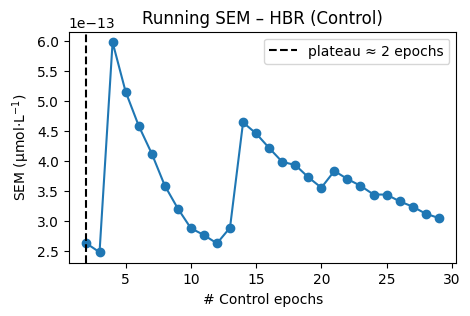

Reading 0 ... 18874  =      0.000 ...  2415.872 secs...
{('hbo', 'Tapping_Left'): {'cohen_d': 1.5153960087909988,
                           'n_needed_theory': 6,
                           'sequential_result': {'boundary': 0.015732899022206242,
                                                 'n_used': 2,
                                                 'p_val': 0.009808069430611186,
                                                 'passed': True,
                                                 't_stat': 64.90261990911789}},
 ('hbo', 'Tapping_Right'): {'cohen_d': 2.306733131362762,
                            'n_needed_theory': 4,
                            'sequential_result': {'boundary': 0.015533373363990298,
                                                  'n_used': 5,
                                                  'p_val': 0.005411399692793278,
                                                  'passed': True,
                                                  't_stat': 5.476

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [206]:
# -------------------------------------------------------------------------
# NEW IMPORTS
# -------------------------------------------------------------------------
import itertools
import pingouin as pg            # pip install pingouin
from statsmodels.stats.power import TTestPower
from statsmodels.stats.weightstats import DescrStatsW
import warnings

# -------------------------------------------------------------------------
# 1 ────────────────────────── BASELINE CHARACTERISATION ───────────────────
# -------------------------------------------------------------------------
def running_sem(values):
    """
    Running standard error of the mean for an iterable of scalar values.
    Returns the SEM after every additional sample in the input order.
    """
    sem = []
    for n in range(1, len(values) + 1):
        sem.append(np.std(values[:n], ddof=1) / np.sqrt(n))
    return np.array(sem)


def plot_control_sem(epochs, time_window, pick_type="hbr", ax=None,
                     negligible_bound=0.05):
    """
    Plot running SEM of the control epochs and mark the 'plateau' point where
    adding one more epoch changes the mean by < negligible_bound (µmol·L⁻¹).
    """
    ctrl_vals = extract_epoch_means(epochs["Control"], time_window, pick_type)
    sem = running_sem(ctrl_vals)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(np.arange(1, len(sem) + 1), sem, marker="o")
    ax.set_xlabel("# Control epochs")
    ax.set_ylabel("SEM (µmol·L$^{-1}$)")
    ax.set_title(f"Running SEM – {pick_type.upper()} (Control)")
    # plateau criterion (mean change < negligible_bound)
    plateau_idx = np.where(sem < negligible_bound)[0]
    if plateau_idx.size:
        plateau_n = plateau_idx[0] + 1
        ax.axvline(plateau_n, color="k", ls="--",
                   label=f"plateau ≈ {plateau_n} epochs")
    ax.legend()
    return ax


def tost_equivalence_to_zero(values, delta=0.05, alpha=0.05):
    """
    Two One-Sided Tests (TOST) equivalence test around 0 ± delta.
    Returns a dictionary with keys: 'pval_lower', 'pval_upper', 'equivalence'.
    """
    import scipy.stats as st
    values = np.asarray(values)
    n = len(values)
    mean_val = np.mean(values)
    sd = np.std(values, ddof=1)
    se = sd / np.sqrt(n)
    # lower bound test: H0: mean <= -delta vs Ha: mean > -delta
    t_lower = (mean_val - (-delta)) / se
    p_lower = 1 - st.t.cdf(t_lower, df=n-1)
    # upper bound test: H0: mean >= delta vs Ha: mean < delta
    t_upper = (mean_val - delta) / se
    p_upper = st.t.cdf(t_upper, df=n-1)
    equivalence = (p_lower < alpha) and (p_upper < alpha)
    return {'pval_lower': p_lower, 'pval_upper': p_upper, 'equivalence': equivalence}

# -------------------------------------------------------------------------
# 2 ────────────────────────────── POWER ANALYSIS ─────────────────────────-
# -------------------------------------------------------------------------
def pilot_effect_size(tapping_vals, control_vals, n_pilot=10):
    """
    Estimate paired-samples Cohen's d from n_pilot epoch pairs.
    """
    n = min(len(tapping_vals), len(control_vals), n_pilot)
    d = pg.compute_effsize(tapping_vals[:n], control_vals[:n], paired=True, eftype="cohen")
    return d


def required_epochs_for_power(effect_size, power=.8, alpha=.05, tail="two-sided"):
    """
    Closed-form solution for paired t-test sample size.
    """
    analysis = TTestPower()
    n = analysis.solve_power(effect_size=effect_size,
                              power=power,
                              alpha=alpha,
                              alternative=tail)
    return int(np.ceil(n))

# -------------------------------------------------------------------------
# 3 ──────────────────── SEQUENTIAL (ACCUMULATING) TEST ───────────────────-
# -------------------------------------------------------------------------
def sequential_paired_t(tapping_vals, control_vals,
                        alpha=.05, spending="pocock"):
    """
    Analyses paired epochs sequentially (in their given order) and stops
    once significance is reached using the specified alpha-spending rule.
    spending ∈ {"pocock", "obf"} (O'Brien-Fleming).
    Returns dictionary with keys:
        'n_used', 't_stat', 'p_val', 'passed', 'boundary'
    """
    n_total = min(len(tapping_vals), len(control_vals))
    # Boundary constants for Pocock and O'Brien-Fleming (approx.)
    if spending == "pocock":
        boundary = alpha / np.log(n_total + 1)
    elif spending in {"obf", "obrien"}:
        boundary = alpha * (np.log((n_total + 1) / 2)) / np.log(n_total + 1)
    else:
        raise ValueError("spending must be 'pocock' or 'obf'")
    for n in range(2, n_total + 1):
        t_stat, p_val = ttest_rel(tapping_vals[:n], control_vals[:n])
        if p_val < boundary:
            return dict(n_used=n, t_stat=t_stat, p_val=p_val,
                        passed=True, boundary=boundary)
    # never crossed
    t_stat, p_val = ttest_rel(tapping_vals[:n_total], control_vals[:n_total])
    return dict(n_used=n_total, t_stat=t_stat, p_val=p_val,
                passed=False, boundary=boundary)

# -------------------------------------------------------------------------
# 4 ───────────────────────────── HIGH-LEVEL DRIVER ───────────────────────-
# -------------------------------------------------------------------------
def analyse_subject(subject=4,
                    baseline_window=(-5, 0),
                    response_window=(0, 11),
                    negligible_bound=.05,
                    n_pilot=10,
                    desired_power=.80):
    """
    End-to-end: (a) baseline SEM + TOST, (b) pilot effect size and power
    calculation, (c) sequential test using just enough epochs, for both
    chromophores and both tapping sides.
    """
    epochs, _ = load_data(subject=subject, time_window=response_window)
    
    results = {}
    for pick in ("hbo", "hbr"):
        # 1 ─ baseline
        ctrl_vals = extract_epoch_means(epochs["Control"],
                                        baseline_window, pick)
        sem = running_sem(ctrl_vals)
        eq = tost_equivalence_to_zero(ctrl_vals,
                                      delta=negligible_bound)
        results[(pick, "baseline")] = dict(
            sem_last=sem[-1],  # final SEM
            n_ctrl=len(ctrl_vals),
            tost_p=max(eq['pval_lower'], eq['pval_upper']),
            equivalent=eq['equivalence']
        )
        # 2 ─ power
        for tap_cond in ("Tapping_Left", "Tapping_Right"):
            tap_vals = extract_epoch_means(epochs[tap_cond],
                                           response_window, pick)
            d = pilot_effect_size(tap_vals, ctrl_vals,
                                  n_pilot=n_pilot)
            n_needed = required_epochs_for_power(d,
                                                 power=desired_power)
            # 3 ─ sequential test
            seq = sequential_paired_t(tap_vals, ctrl_vals)
            results[(pick, tap_cond)] = dict(
                cohen_d=d,
                n_needed_theory=n_needed,
                sequential_result=seq
            )
    return results
if __name__ == "__main__":
    subject = 2
    # ❶ Visualise baseline convergence for HbR (most sensitive)
    ax = plot_control_sem(epochs, time_window=(-5, 0), pick_type="hbr",
                          negligible_bound=0.05)
    plt.show()

    # ❷ Full statistics for the chosen subject
    stats = analyse_subject(subject=subject,
                            baseline_window=(-5, 0),
                            response_window=(0, 11))
    import pprint; pprint.pprint(stats, compact=True)


In [207]:
def analyse_control_test(subject=4,
                         baseline_window=(-5, 0),
                         response_window=(0, 11),
                         negligible_bound=.05,
                         n_pilot=10,
                         desired_power=.80,
                         baseline_ratio=0.75):
    """
    Performs the same tests as analyse_subject but uses a left‐out subset of CONTROL epochs
    as a pseudo tapping condition (named 'tapping_2_left'). Baseline is computed from the first
    (baseline_ratio) proportion of control epochs and the remaining epochs are treated as the test.
    """
    epochs, _ = load_data(subject=subject, time_window=response_window)
    ctrl_epochs = epochs["Control"]
    n_epochs = len(ctrl_epochs)
    split_idx = int(n_epochs * baseline_ratio)
    baseline_ctrl = ctrl_epochs[:split_idx]
    pseudo_tap = ctrl_epochs[split_idx:]
    
    results = {}
    for pick in ("hbo", "hbr"):
        # 1 ─ baseline (from first 75% of control epochs)
        baseline_vals = extract_epoch_means(baseline_ctrl, baseline_window, pick)
        sem = running_sem(baseline_vals)
        eq = tost_equivalence_to_zero(baseline_vals, delta=negligible_bound)
        results[(pick, "baseline")] = dict(
            sem_last=sem[-1],
            n_ctrl=len(baseline_vals),
            tost_p=max(eq['pval_lower'], eq['pval_upper']),
            equivalent=eq['equivalence']
        )
        # 2 ─ pseudo tapping test (the remaining 25% of control epochs)
        pseudo_vals = extract_epoch_means(pseudo_tap, response_window, pick)
        d = pilot_effect_size(pseudo_vals, baseline_vals, n_pilot=n_pilot)
        n_needed = required_epochs_for_power(d, power=desired_power)
        seq = sequential_paired_t(pseudo_vals, baseline_vals)
        results[(pick, "tapping_2_left")] = dict(
            cohen_d=d,
            n_needed_theory=n_needed,
            sequential_result=seq
        )
    return results

if __name__ == "__main__":
    # ...existing code...
    print("\n--- Control test (pseudo tapping_2_left) ---")
    ctrl_test_stats = analyse_control_test(subject=subject,
                                             baseline_window=(-5, 0),
                                             response_window=(0, 11))
    import pprint; pprint.pprint(ctrl_test_stats, compact=True)


--- Control test (pseudo tapping_2_left) ---
Reading 0 ... 18874  =      0.000 ...  2415.872 secs...
{('hbo', 'baseline'): {'equivalent': True,
                       'n_ctrl': 18,
                       'sem_last': 8.96204870854652e-12,
                       'tost_p': 5.578949776521056e-157},
 ('hbo', 'tapping_2_left'): {'cohen_d': 1.967312821545084,
                             'n_needed_theory': 5,
                             'sequential_result': {'boundary': 0.025694917118487537,
                                                   'n_used': 6,
                                                   'p_val': 0.023040482730794575,
                                                   'passed': True,
                                                   't_stat': 3.236430109682165}},
 ('hbr', 'baseline'): {'equivalent': True,
                       'n_ctrl': 18,
                       'sem_last': 3.0504031345727194e-13,
                       'tost_p': 6.161712116096143e-182},
 ('hbr', 'tappin

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reading 0 ... 18877  =      0.000 ...  2416.256 secs...
Tapping left: 2.6054218109198938e-09
Control: 3.912407718389112e-09
Tapping Left vs. Control (HbO): t = -0.624, p = 0.543
Tapping Left vs. Control (HbR): t = 0.229, p = 0.823
Tapping right: 2.248860487113252e-09
Tapping Right vs. Control (HbO): t = 1.119, p = 0.300
Tapping Right vs. Control (HbR): t = -0.044, p = 0.966
Reading 0 ... 18877  =      0.000 ...  2416.256 secs...
Control Split (HbO): t = 0.513, p = 0.621
Control Split (HbR): t = 1.015, p = 0.336
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


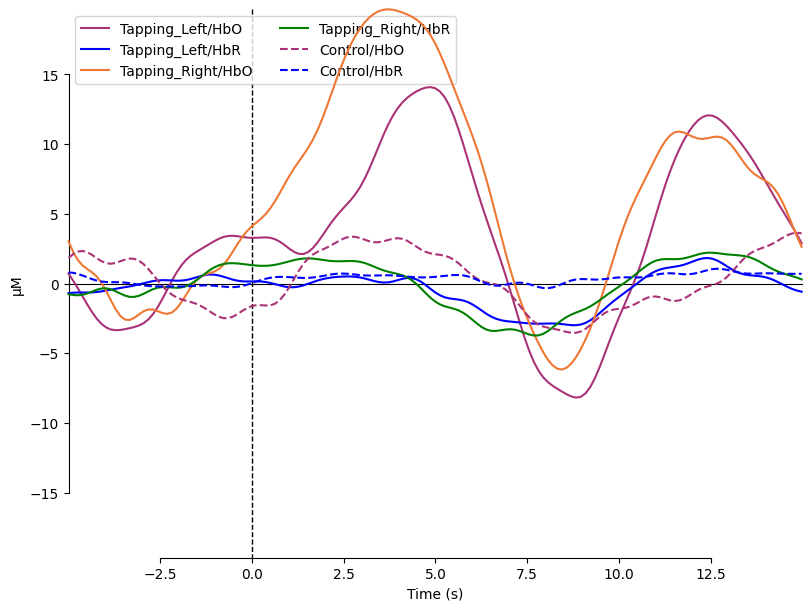

[<Figure size 800x600 with 1 Axes>]

In [208]:
subject = 1
time_window = (0, 11)

epochs, evoked_dict = load_data(subject=subject, time_window=time_window)

color_dict = {
"Tapping_Left/HbO": "#AA3377",
"Tapping_Left/HbR": "b",
"Tapping_Right/HbO": "#EE7733",
"Tapping_Right/HbR": "g",
"Control/HbO": "#AA3377",
"Control/HbR": "b",
}
styles_dict = dict(Control=dict(linestyle="dashed"))

# Perform paired t-tests for tapping vs. control
perform_t_tests(epochs, time_window)
# Perform control split t-tests
perform_control_split_t_tests(subject, time_window)

# Plot evoked comparisons using MNE's viz
mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)

Reading 0 ... 23006  =      0.000 ...  2944.768 secs...
Tapping left: 5.7633941690440775e-09
Control: 3.72619680511334e-09
Tapping Left vs. Control (HbO): t = 2.626, p = 0.014
Tapping Left vs. Control (HbR): t = 4.772, p = 0.000
Tapping right: 4.537178873726537e-09
Tapping Right vs. Control (HbO): t = 0.845, p = 0.405
Tapping Right vs. Control (HbR): t = 3.858, p = 0.001
Reading 0 ... 23006  =      0.000 ...  2944.768 secs...
Control Split (HbO): t = -0.941, p = 0.363
Control Split (HbR): t = -0.692, p = 0.500
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


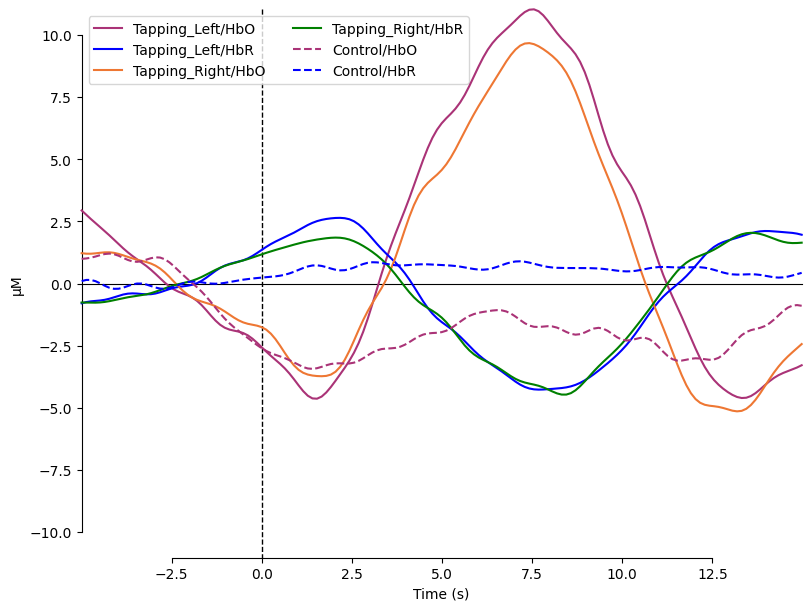

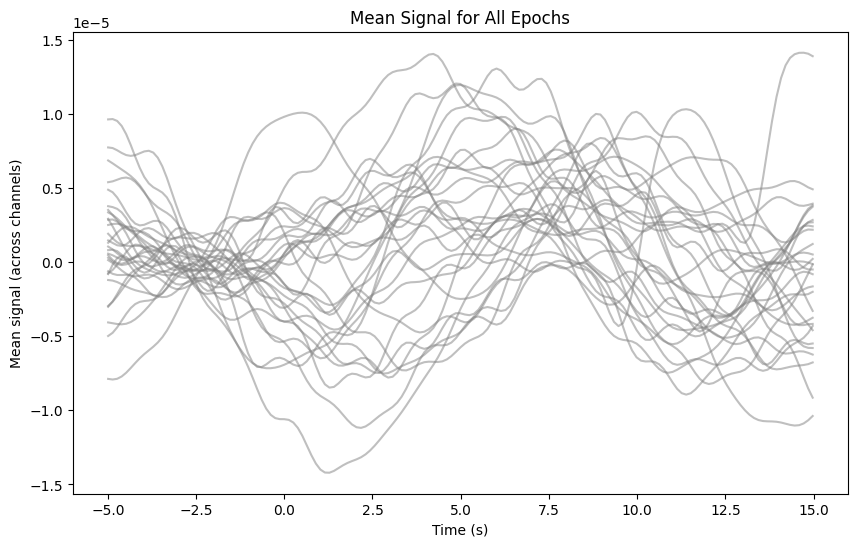

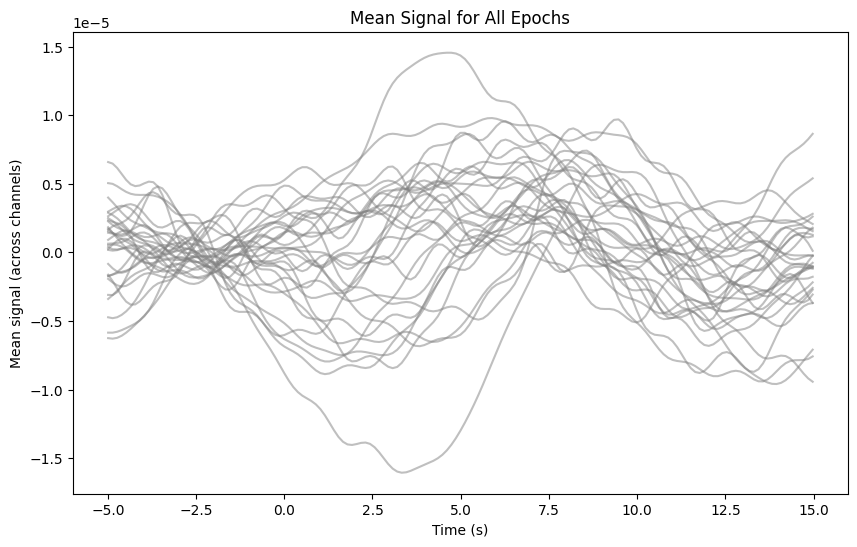

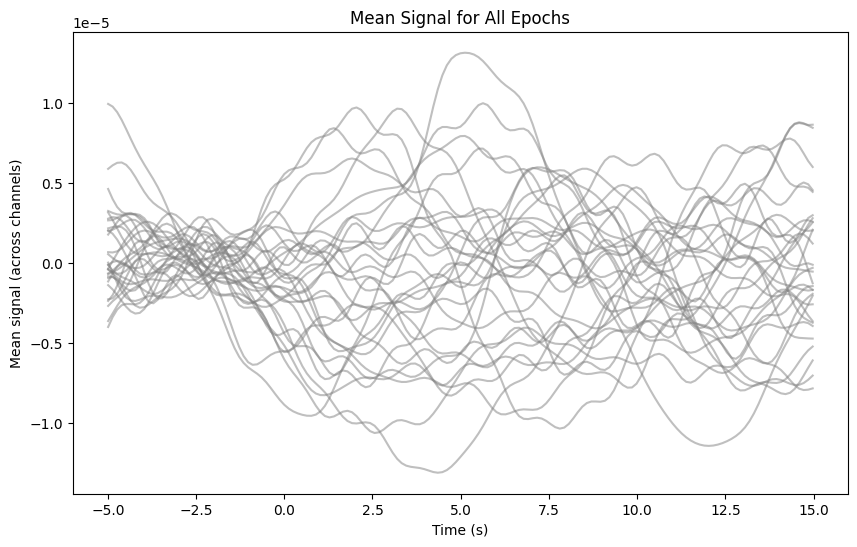

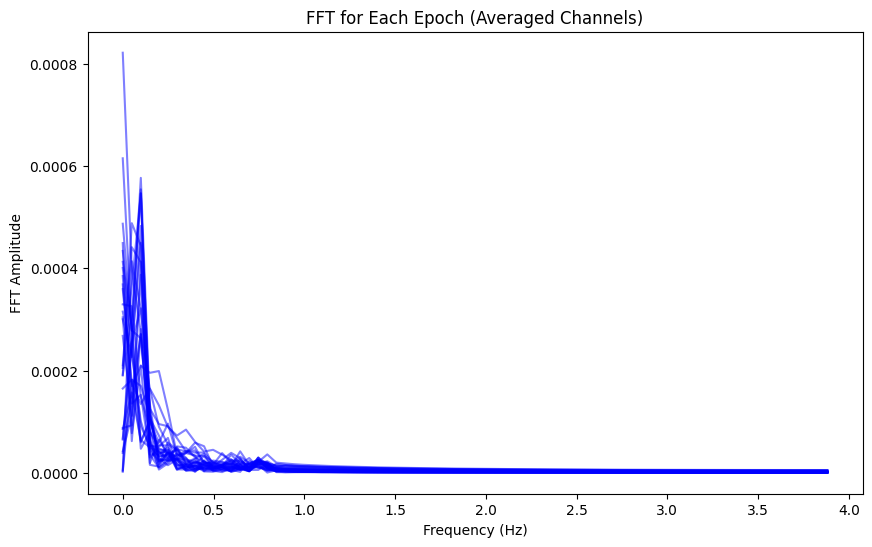

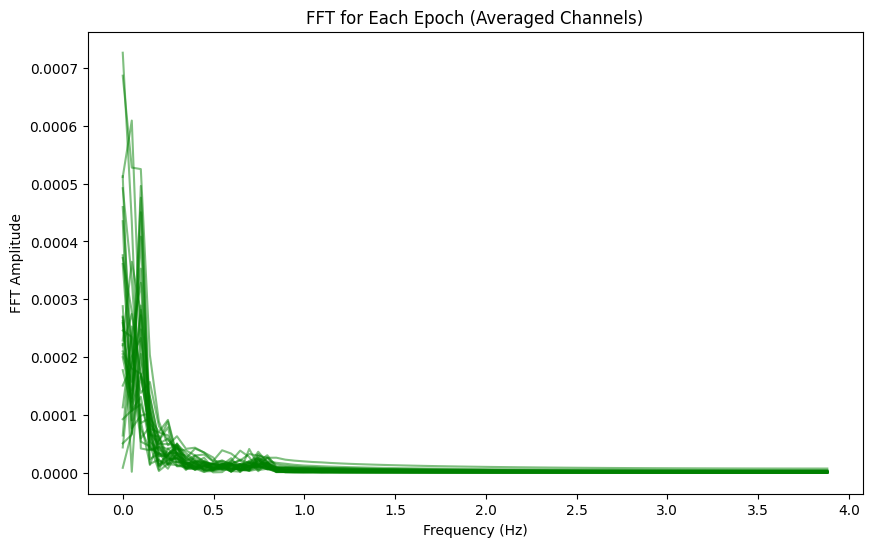

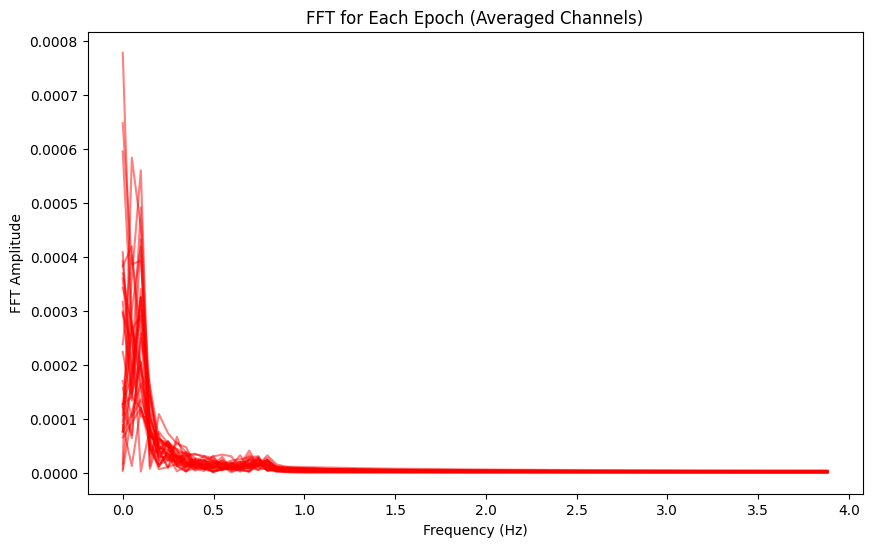

In [217]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import mne
from scipy.stats import ttest_rel

# Insert the parent folder for custom modules
sys.path.insert(0, os.path.abspath('..'))
from Preprocessing.preprocessing_mne import get_raw_subject_data, get_raw_control_subject_data

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

def load_data(subject=3, time_window=(-5, 15)):
    """
    Load data, perform averaging tests and plots for evoked responses,
    and return concatenated data along with original epoch information.
    
    This function retains all mean tests and plots of averaged epochs.
    ICA-related functionality has been removed.
    
    Returns:
        tuple: (X, orig_indices, y, control_data, left_data, right_data, numb_samples)
    """

    # tmin = time_window[0]
    # tmax = time_window[1]
    tmin = -5.0
    tmax = 15.0

    # Load subject epochs
    epochs = get_raw_subject_data(subject=subject, tmin=tmin, tmax=tmax)

    # Compute evoked responses for each condition and rename channels
    evoked_dict = {
        "Tapping_Left/HbO": epochs["Tapping_Left"].average(picks="hbo"),
        "Tapping_Left/HbR": epochs["Tapping_Left"].average(picks="hbr"),
        "Tapping_Right/HbO": epochs["Tapping_Right"].average(picks="hbo"),
        "Tapping_Right/HbR": epochs["Tapping_Right"].average(picks="hbr"),
        "Control/HbO": epochs["Control"].average(picks="hbo"),
        "Control/HbR": epochs["Control"].average(picks="hbr"),
    }
    for condition in evoked_dict:
        evoked_dict[condition].rename_channels(lambda x: x[:-4])

    return epochs, evoked_dict


def extract_epoch_means(epochs_obj, time_window, pick_type):
    """
    Compute the mean power for each epoch over channels and a time window.
    
    Parameters:
        epochs_obj: MNE Epochs object.
        time_window: tuple (t_min, t_max) in seconds.
        pick_type: string (e.g., 'hbo' or 'hbr').
    
    Returns:
        1D array with mean power (i.e., average of the squared signal) for each epoch.
    """
    data = epochs_obj.get_data(picks=pick_type)
    idx = np.where((epochs_obj.times >= time_window[0]) & (epochs_obj.times <= time_window[1]))[0]
    return np.mean(np.square(data[:, :, idx]), axis=(1, 2))


def plot_mean_evoked_responses(evoked_dict, color_dict, styles_dict):
    """
    Plot the mean evoked responses (averaging over channels) for each condition.
    """
    plt.figure(figsize=(10, 6))
    for condition, ev in evoked_dict.items():
        mean_signal = np.mean(ev.data, axis=0)
        cond_key = condition.split('/')[0]
        linestyle = styles_dict.get(cond_key, {}).get("linestyle", "-")
        color = color_dict.get(condition)
        plt.plot(ev.times, mean_signal, label=condition, color=color, linestyle=linestyle)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Mean Evoked Response (Channels Averaged)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


# def perform_t_tests(epochs, time_window):
#     """
#     Compute paired t-tests for tapping versus control epochs.
#     """
#     tapping_hbo = extract_epoch_means(epochs["Tapping_Left"], time_window, "hbo")
#     control_hbo = extract_epoch_means(epochs["Control"], time_window, "hbo")
#     tapping_hbr = extract_epoch_means(epochs["Tapping_Left"], time_window, "hbr")
#     control_hbr = extract_epoch_means(epochs["Control"], time_window, "hbr")

#     n_epochs = min(tapping_hbo.shape[0], control_hbo.shape[0])
#     tapping_hbo, control_hbo = tapping_hbo[:n_epochs], control_hbo[:n_epochs]
#     tapping_hbr, control_hbr = tapping_hbr[:n_epochs], control_hbr[:n_epochs]

#     t_stat_hbo, p_val_hbo = ttest_rel(tapping_hbo, control_hbo)
#     t_stat_hbr, p_val_hbr = ttest_rel(tapping_hbr, control_hbr)

#     print("Tapping vs. Control (HbO): t = {:.3f}, p = {:.3f}".format(t_stat_hbo, p_val_hbo))
#     print("Tapping vs. Control (HbR): t = {:.3f}, p = {:.3f}".format(t_stat_hbr, p_val_hbr))

def perform_t_tests(epochs, time_window):
    """
    Compute paired t-tests for tapping (left and right) versus control epochs.
    """
    # Tapping Left vs. Control
    tapping_left_hbo = extract_epoch_means(epochs["Tapping_Left"], time_window, "hbo")
    print(f"Tapping left: {sum(tapping_left_hbo)}")
    control_hbo = extract_epoch_means(epochs["Control"], time_window, "hbo")
    print(f"Control: {sum(control_hbo)}")
    tapping_left_hbr = extract_epoch_means(epochs["Tapping_Left"], time_window, "hbr")
    control_hbr = extract_epoch_means(epochs["Control"], time_window, "hbr")
    
    n_epochs_left = min(tapping_left_hbo.shape[0], control_hbo.shape[0])
    tapping_left_hbo, control_hbo_left = tapping_left_hbo[:n_epochs_left], control_hbo[:n_epochs_left]
    tapping_left_hbr, control_hbr_left = tapping_left_hbr[:n_epochs_left], control_hbr[:n_epochs_left]
    
    t_stat_left_hbo, p_val_left_hbo = ttest_rel(tapping_left_hbo, control_hbo_left)
    t_stat_left_hbr, p_val_left_hbr = ttest_rel(tapping_left_hbr, control_hbr_left)
    
    print("Tapping Left vs. Control (HbO): t = {:.3f}, p = {:.3f}".format(t_stat_left_hbo, p_val_left_hbo))
    print("Tapping Left vs. Control (HbR): t = {:.3f}, p = {:.3f}".format(t_stat_left_hbr, p_val_left_hbr))
    
    # Tapping Right vs. Control
    tapping_right_hbo = extract_epoch_means(epochs["Tapping_Right"], time_window, "hbo")
    print(f"Tapping right: {sum(tapping_right_hbo)}")
    tapping_right_hbr = extract_epoch_means(epochs["Tapping_Right"], time_window, "hbr")
    
    n_epochs_right = min(tapping_right_hbo.shape[0], control_hbo.shape[0])
    tapping_right_hbo, control_hbo_right = tapping_right_hbo[:n_epochs_right], control_hbo[:n_epochs_right]
    tapping_right_hbr, control_hbr_right = tapping_right_hbr[:n_epochs_right], control_hbr[:n_epochs_right]
    
    t_stat_right_hbo, p_val_right_hbo = ttest_rel(tapping_right_hbo, control_hbo_right)
    t_stat_right_hbr, p_val_right_hbr = ttest_rel(tapping_right_hbr, control_hbr_right)
    
    print("Tapping Right vs. Control (HbO): t = {:.3f}, p = {:.3f}".format(t_stat_right_hbo, p_val_right_hbo))
    print("Tapping Right vs. Control (HbR): t = {:.3f}, p = {:.3f}".format(t_stat_right_hbr, p_val_right_hbr))


def perform_control_split_t_tests(subject, time_window):
    """
    Split control epochs randomly into two sets and compute
    paired t-tests for the activation over the given time window.
    """
    control_epochs = get_raw_control_subject_data(subject=subject)
    data = control_epochs.get_data()
    n_epochs = data.shape[0]
    perm = np.random.permutation(n_epochs)
    half = n_epochs // 2
    set1_indices = perm[:half]
    set2_indices = perm[half:half*2]

    control_set1 = control_epochs[set1_indices]
    control_set2 = control_epochs[set2_indices]

    mean_set1_hbo = extract_epoch_means(control_set1, time_window, "hbo")
    mean_set2_hbo = extract_epoch_means(control_set2, time_window, "hbo")
    mean_set1_hbr = extract_epoch_means(control_set1, time_window, "hbr")
    mean_set2_hbr = extract_epoch_means(control_set2, time_window, "hbr")

    t_stat_hbo, p_val_hbo = ttest_rel(mean_set1_hbo, mean_set2_hbo)
    t_stat_hbr, p_val_hbr = ttest_rel(mean_set1_hbr, mean_set2_hbr)

    print("Control Split (HbO): t = {:.3f}, p = {:.3f}".format(t_stat_hbo, p_val_hbo))
    print("Control Split (HbR): t = {:.3f}, p = {:.3f}".format(t_stat_hbr, p_val_hbr))


subject = 4
time_window = (0, 11)

epochs, evoked_dict = load_data(subject=subject, time_window=time_window)

color_dict = {
"Tapping_Left/HbO": "#AA3377",
"Tapping_Left/HbR": "b",
"Tapping_Right/HbO": "#EE7733",
"Tapping_Right/HbR": "g",
"Control/HbO": "#AA3377",
"Control/HbR": "b",
}
styles_dict = dict(Control=dict(linestyle="dashed"))

# Perform paired t-tests for tapping vs. control
perform_t_tests(epochs, time_window)
# Perform control split t-tests
perform_control_split_t_tests(subject, time_window)

# Plot evoked comparisons using MNE's viz
mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)


def plot_all_epochs_mean(epochs_obj, color='gray'):
    """
    Plot each epoch of an MNE Epochs object.
    For each epoch, compute the mean across channels at each time point,
    and plot the resulting time-series.
    
    Parameters:
        epochs_obj: MNE Epochs object containing trials of a single condition.
        color: color for each epoch line.
    """
    data = epochs_obj.get_data()  # shape: (n_epochs, n_channels, n_times)
    times = epochs_obj.times
    plt.figure(figsize=(10, 6))
    for epoch_data in data:
        mean_signal = epoch_data.mean(axis=0)  # average over channels
        plt.plot(times, mean_signal, color=color, alpha=0.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Mean signal (across channels)")
    plt.title("Mean Signal for All Epochs")
    plt.show()


# Example usage for a specific condition (e.g., Tapping_Left):
plot_all_epochs_mean(epochs["Tapping_Left"])
plot_all_epochs_mean(epochs["Tapping_Right"])
plot_all_epochs_mean(epochs["Control"])


def plot_fft_epochs(epochs_obj, color='gray'):
    """
    For each epoch in the given MNE Epochs object, compute the mean across channels,
    perform an FFT on the resulting signal, and plot the FFT amplitude spectrum.

    Parameters:
        epochs_obj: MNE Epochs object containing trials of a single condition.
        color: Color for each FFT line.
    """
    data = epochs_obj.get_data()  # shape: (n_epochs, n_channels, n_times)
    sfreq = epochs_obj.info['sfreq']  # sampling frequency
    plt.figure(figsize=(10, 6))
    for epoch_data in data:
        # Average over channels
        avg_signal = epoch_data.mean(axis=0)
        N = len(avg_signal)
        # Compute FFT (using only the positive frequencies)
        fft_vals = np.abs(np.fft.rfft(avg_signal))
        freqs = np.fft.rfftfreq(N, d=1/sfreq)
        plt.plot(freqs, fft_vals, color=color, alpha=0.5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("FFT Amplitude")
    plt.title("FFT for Each Epoch (Averaged Channels)")
    plt.show()
    
# Example usage:
# Plot FFT for each epoch in the Tapping_Left condition:
plot_fft_epochs(epochs["Tapping_Left"], color='blue')

# Similarly, you can plot for Tapping_Right or Control:
plot_fft_epochs(epochs["Tapping_Right"], color='green')
plot_fft_epochs(epochs["Control"], color='red')

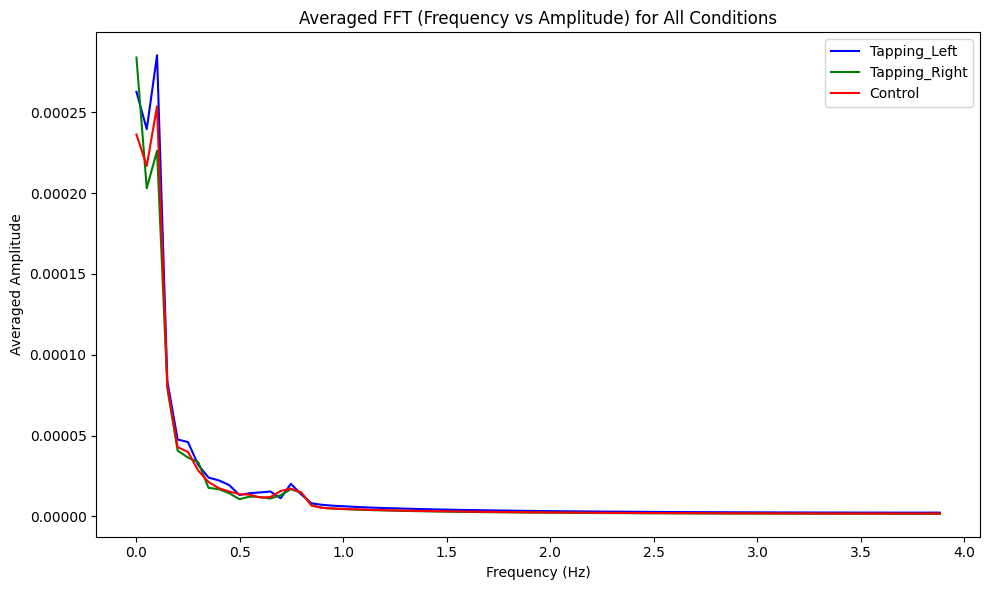

In [218]:
def plot_average_fft_all_conditions(epochs_dict, colors=None):
    """
    For each condition in the given epochs dictionary, compute the FFT for each epoch 
    (after averaging over channels), average the FFT amplitudes over epochs, 
    and plot the averaged frequency vs. amplitude curves.
    
    Parameters:
        epochs_dict: dict
            Dictionary where keys are condition names and values are MNE Epochs objects.
        colors: dict, optional
            Dictionary mapping condition names to plot colors.
    """
    plt.figure(figsize=(10, 6))
    for condition, epochs_obj in epochs_dict.items():
        data = epochs_obj.get_data()  # shape: (n_epochs, n_channels, n_times)
        sfreq = epochs_obj.info['sfreq']
        fft_list = []
        for epoch in data:
            # Compute the mean across channels for this epoch
            avg_signal = np.mean(epoch, axis=0)
            # Compute FFT amplitude (only positive frequencies)
            fft_vals = np.abs(np.fft.rfft(avg_signal))
            fft_list.append(fft_vals)
        fft_array = np.array(fft_list)  # shape: (n_epochs, n_freqs)
        # Average FFT amplitude over all epochs
        avg_fft = np.mean(fft_array, axis=0)
        # Compute frequency bins based on the length of the FFT and sampling frequency
        N = avg_signal.shape[0]
        freqs = np.fft.rfftfreq(N, d=1/sfreq)
        col = colors.get(condition) if colors and condition in colors else None
        plt.plot(freqs, avg_fft, label=condition, color=col)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Averaged Amplitude")
    plt.title("Averaged FFT (Frequency vs Amplitude) for All Conditions")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


# Example usage:
# Create a dictionary with keys for each condition from the epochs
conditions = {
    "Tapping_Left": epochs["Tapping_Left"],
    "Tapping_Right": epochs["Tapping_Right"],
    "Control": epochs["Control"]
}

# Optionally, define specific colors for each condition
fft_colors = {
    "Tapping_Left": "blue",
    "Tapping_Right": "green",
    "Control": "red"
}

plot_average_fft_all_conditions(conditions, fft_colors)

In [211]:
# ---------------------------------------------------------------------
# ----------  Detect “real” tapping epochs vs. control noise ----------
# ---------------------------------------------------------------------
def _auc(signal, times, window=(1, 8)):
    idx = np.where((times >= window[0]) & (times <= window[1]))[0]
    return np.trapz(signal[idx], x=times[idx])

def find_active_epochs(tap_epo, ctrl_epo, picks="hbo",
                       auc_window=(1, 8), z_thresh=2.0, r_thresh=0.30):
    """
    Return indices of tap_epo that (i) have large AUC compared to control
    and (ii) resemble the canonical haemodynamic shape.
    """
    times = tap_epo.times

    # --- null distribution from control --------------------------------
    ctrl_auc = [_auc(e.mean(axis=0), times, auc_window)
                for e in ctrl_epo.get_data(picks=picks)]
    mu, sigma = np.mean(ctrl_auc), np.std(ctrl_auc, ddof=1) or 1e-12

    # --- score each tapping trial --------------------------------------
    tap_dat = tap_epo.get_data(picks=picks)
    tap_auc = np.array([_auc(e.mean(axis=0), times, auc_window)
                        for e in tap_dat])
    z = (tap_auc - mu) / sigma

    # --- correlation with canonical response ---------------------------
    template = tap_dat.mean(axis=0).mean(axis=0)            # (n_times,)
    r = np.array([np.corrcoef(e.mean(axis=0), template)[0, 1]
                  for e in tap_dat])

    active = np.where((z > z_thresh) & (r > r_thresh))[0]
    return active, z, r

# -----------------------  run the detector  ---------------------------
left_idx,  left_z,  left_r  = find_active_epochs(epochs["Tapping_Left"],
                                                 epochs["Control"],
                                                 picks="hbo")
right_idx, right_z, right_r = find_active_epochs(epochs["Tapping_Right"],
                                                 epochs["Control"],
                                                 picks="hbo")

print(f"Left-tap active epochs : {len(left_idx)} / {len(epochs['Tapping_Left'])}")
print(f"Right-tap active epochs: {len(right_idx)} / {len(epochs['Tapping_Right'])}")

# Optionally create Epochs objects containing only the active trials
epochs_left_active  = epochs["Tapping_Left" ][left_idx ]
epochs_right_active = epochs["Tapping_Right"][right_idx]


Left-tap active epochs : 4 / 28
Right-tap active epochs: 4 / 27


In [212]:
# --------------------------------------------------------------------
# -------  brute-force (or sampled) averages of epoch combinations ---
# --------------------------------------------------------------------
import itertools

def _combo_auc_distribution(epochs_obj, time_window=(0, 11), picks="hbo",
                            min_group=5, max_combos=10_000):
    """
    For every group-size k (min_group … n_epochs) compute the AUC of the
    *channel- and epoch-average* HbO time-series obtained by averaging
    exactly k epochs.

    Parameters
    ----------
    epochs_obj : mne.Epochs
        The epochs of one experimental condition.
    time_window : tuple
        Integration window (start, stop) in seconds.
    picks : str
        'hbo' or 'hbr'.
    min_group : int
        Smallest combination size to test.
    max_combos : int
        Safety cap – if the number of combinations at a given k exceeds
        this value, draw a random sample of `max_combos` combinations.
    """
    data  = epochs_obj.get_data(picks=picks)          # (n_epochs, n_ch, n_t)
    times = epochs_obj.times
    idx   = np.where((times >= time_window[0]) &
                     (times <= time_window[1]))[0]

    n_epochs = data.shape[0]
    auc_dict = {}

    rng = np.random.default_rng(seed=42)              # reproducible sampling

    for k in range(min_group, n_epochs + 1):
        comb_iter = itertools.combinations(range(n_epochs), k)
        # sample if the full set is gigantic
        if math.comb(n_epochs, k) > max_combos:
            comb_iter = rng.choice(list(comb_iter), size=max_combos,
                                   replace=False)

        auc_vals = []
        for combo in comb_iter:
            avg_sig = data[list(combo)].mean(axis=0).mean(axis=0)  # (n_t,)
            auc     = np.trapz(avg_sig[idx], x=times[idx])
            auc_vals.append(auc)
        auc_dict[k] = np.array(auc_vals)

    return auc_dict


# -------------------------  run the analysis  -------------------------
import math

combo_results = {}
for cond in ["Tapping_Left", "Tapping_Right", "Control"]:
    combo_results[cond] = _combo_auc_distribution(epochs[cond],
                                                  time_window=time_window,
                                                  picks="hbo",
                                                  min_group=5,
                                                  max_combos=5000)

    print(f"\n{cond} — AUC(|μM·s|) over combination sizes")
    for k, vals in combo_results[cond].items():
        print(f"  k={k:2d}:  mean={np.abs(vals).mean():.3e} "
              f"± {np.abs(vals).std():.3e}   (n={len(vals)})")


KeyboardInterrupt: 

In [ ]:
# ------------------------------------------------------------------
# ----------  statistical test: tapping combos vs. control ----------
# ------------------------------------------------------------------
from scipy.stats import ttest_ind, combine_pvalues

def combo_stats(combo_res, cond, alpha=0.05):
    """
    Compare the AUC-distributions of all k-epoch combinations of `cond`
    against those of Control.  Uses Welch t-tests for every k, then
    combines the p-values with Fisher’s method.
    """
    ctrl = combo_res["Control"]
    ks   = sorted(set(combo_res[cond]).intersection(ctrl))

    p_vals = []
    for k in ks:
        p = ttest_ind(combo_res[cond][k],
                      ctrl[k],
                      equal_var=False).pvalue
        p_vals.append(p)

    # combine the evidence across all k
    _, p_combined = combine_pvalues(p_vals, method="fisher")

    print(f"\n{cond}:")
    print(f"  min-p across k = {min(p_vals):.3e}")
    print(f"  Fisher combined p = {p_combined:.3e}")

    if p_combined < alpha:
        print("  → significant task-related haemodynamic response detected")
    else:
        print("  → no significant response (within this dataset)")

# run for both tapping conditions
combo_stats(combo_results, "Tapping_Left" )
combo_stats(combo_results, "Tapping_Right")



Tapping_Left:
  min-p across k = 0.000e+00
  Fisher combined p = nan
  → no significant response (within this dataset)

Tapping_Right:
  min-p across k = 0.000e+00
  Fisher combined p = nan
  → no significant response (within this dataset)


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [ ]:
# ------------------------------------------------------------------
# ----  does ANY tapping combination fall outside control limits? --
# ------------------------------------------------------------------
import numpy as np

def combo_outlier_report(combo_res, cond, alpha=0.05):
    """
    For every group size k:
        • compute the (α/2, 1-α/2) quantile band of the CONTROL combos.
        • ask how many TAPPING combos lie outside that band.
    Prints a summary and returns a dict {k: idx_array}.
    """
    ctrl = combo_res["Control"]
    tap  = combo_res[cond]
    ks   = sorted(set(ctrl) & set(tap))

    sig_combos = {}            # will hold indices of significant combos

    for k in ks:
        ctrl_vals = ctrl[k]
        tap_vals  = tap [k]

        # two-sided (α) envelope of control distribution
        lo, hi = np.percentile(ctrl_vals, [alpha/2*100, (1-alpha/2)*100])

        # combos whose AUC falls outside that envelope
        idx = np.where((tap_vals < lo) | (tap_vals > hi))[0]
        if idx.size:
            sig_combos[k] = idx

        print(f"k={k:2d}:  {idx.size:4d} / {tap_vals.size:5d} "
              f"tapping combos exceed [{lo:.2e}, {hi:.2e}]")

    if sig_combos:
        print(f"\n➜  {cond}: at least one combo is significantly different "
              f"from control →  **patient shows task-related activity**")
    else:
        print(f"\n➜  {cond}: no combo differs from control at α={alpha} "
              f"→  **no evidence of task-related activity**")

    return sig_combos


# --------------------  run the outlier test  -----------------------
left_sig  = combo_outlier_report(combo_results, "Tapping_Left" )
right_sig = combo_outlier_report(combo_results, "Tapping_Right")


k= 5:  2347 /  5000 tapping combos exceed [-4.33e-05, 5.50e-05]
k= 6:  2684 /  5000 tapping combos exceed [-3.61e-05, 5.03e-05]
k= 7:  2984 /  5000 tapping combos exceed [-3.22e-05, 4.55e-05]
k= 8:  3224 /  5000 tapping combos exceed [-2.75e-05, 4.21e-05]
k= 9:  3618 /  5000 tapping combos exceed [-2.54e-05, 3.87e-05]
k=10:  3805 /  5000 tapping combos exceed [-2.23e-05, 3.73e-05]
k=11:  4099 /  5000 tapping combos exceed [-2.09e-05, 3.42e-05]
k=12:  4314 /  5000 tapping combos exceed [-1.91e-05, 3.26e-05]
k=13:  4594 /  5000 tapping combos exceed [-1.64e-05, 3.00e-05]
k=14:  4750 /  5000 tapping combos exceed [-1.44e-05, 2.81e-05]
k=15:  4875 /  5000 tapping combos exceed [-1.24e-05, 2.67e-05]
k=16:  4953 /  5000 tapping combos exceed [-1.02e-05, 2.52e-05]
k=17:  4988 /  5000 tapping combos exceed [-9.17e-06, 2.40e-05]
k=18:  4997 /  5000 tapping combos exceed [-7.69e-06, 2.18e-05]
k=19:  5000 /  5000 tapping combos exceed [-5.75e-06, 2.00e-05]
k=20:  1771 /  1771 tapping combos excee

In [ ]:
# ---------------------------------------------------------------
# ---- 75 % of control = baseline · 25 % of control = “test” ----
# ---------------------------------------------------------------
import math
rng = np.random.default_rng(seed=42)

# --- split control epochs ------------------------------------------------
ctrl_epo      = epochs["Control"]
n_ctrl        = len(ctrl_epo)
perm          = rng.permutation(n_ctrl)
split         = int(0.75 * n_ctrl)
base_idx      = perm[:split]          # 75 % → baseline
test_idx      = perm[split:]          # 25 % → pseudo-patient

ctrl_base_epo = ctrl_epo[base_idx]
ctrl_test_epo = ctrl_epo[test_idx]

# --- build AUC-combo distributions for both parts ------------------------
ctrl_base_res = _combo_auc_distribution(ctrl_base_epo,
                                        time_window=time_window,
                                        picks="hbo",
                                        min_group=5,
                                        max_combos=5000)

ctrl_test_res = _combo_auc_distribution(ctrl_test_epo,
                                        time_window=time_window,
                                        picks="hbo",
                                        min_group=5,
                                        max_combos=5000)

# --- envelope test: do *any* 25 % combos exceed the 75 % band? -----------
def subset_outlier_report(base_res, test_res, alpha=0.05):
    ks   = sorted(set(base_res) & set(test_res))
    sig  = False
    print("\nControl-25 % vs. Control-75 % envelope test")
    for k in ks:
        lo, hi  = np.percentile(base_res[k],
                                [alpha/2*100, (1-alpha/2)*100])
        idx_out = np.where((test_res[k] < lo) | (test_res[k] > hi))[0]
        print(f"k={k:2d}: {idx_out.size:4d} / {len(test_res[k]):4d} "
              f"combos outside [{lo:.2e}, {hi:.2e}]")
        if idx_out.size:
            sig = True
    if sig:
        print(f"➜  Some 25 % control combos lie outside the 75 % envelope "
              f"(α={alpha})")
    else:
        print(f"➜  All 25 % control combos are within the 75 % envelope "
              f"(α={alpha})")

subset_outlier_report(ctrl_base_res, ctrl_test_res, alpha=0.05)



Control-25 % vs. Control-75 % envelope test
k= 5:    4 /   56 combos outside [-8.43e-05, 1.84e-05]
k= 6:    3 /   28 combos outside [-7.95e-05, 1.42e-05]
k= 7:    1 /    8 combos outside [-7.43e-05, 9.93e-06]
k= 8:    0 /    1 combos outside [-6.87e-05, 6.28e-06]
➜  Some 25 % control combos lie outside the 75 % envelope (α=0.05)
